## Starting the ga-wazpy code

Setting a few packages. The package scikit-image is needed. Install it locally using conda <br>
in the terminal and after restart the kernel. 

Run these 2 lines below in terminal and after that restart kernel:
python -m pip install -U --user pip
python -m pip install -U --user scikit-image

Transformation from DECam g and r to V absolute magnitude: V = g - 0.58*(g-r) - 0.01 (Jester 2005, from SDSS to V)

In [1]:
## Run in terminal and select gawa kernel:
# conda create -n gawa python=3.6
# conda activate gawa
# conda install ipykernel
# conda install -c conda-forge cfitsio=3.430
# conda install -c cta-observatory sparse2d
# conda install pip
# pip install -r requirements.txt
# conda install numpy
# ipython kernel install --user --name=gawa

import sys
import os

warn_level = 'ignore'

if not sys.warnoptions:
    import warnings
    warnings.simplefilter(warn_level)
    os.environ["PYTHONWARNINGS"] = warn_level

import numpy as np
import json

from lib.multithread import split_equal_area_in_threads
from lib.utils import hpx_split_survey
from lib.utils import read_FitsCat, create_directory
from lib.utils import create_mosaic_footprint, create_survey_footprint_from_mosaic
from lib.utils import add_key_to_fits, concatenate_clusters
from lib.utils import tile_radius, create_tile_specs
from lib.utils import read_mosaicFitsCat_in_disc, create_directory 
from lib.utils import read_mosaicFootprint_in_disc
from lib.utils import add_clusters_unique_id
from lib.gawa import compute_cmd_masks, compute_dslices, create_gawa_directories
from lib.gawa import gawa_tile, tile_dir_name
from lib.gawa import cl_duplicates_filtering

import parsl
from parsl.app.app import python_app
from parsl.configs.local_threads import config

from tqdm import tqdm

from time import sleep

parsl.load(config)

In [2]:
@python_app
def gawa_thread_call(param, thread_id):
    """_summary_

    Args:
        param (_type_): _description_
        thread_id (_type_): _description_
    """

    import os
    from astropy.table import Table

    workdir = param['out_paths']['workdir']

    all_tiles = read_FitsCat(os.path.join(workdir, param['admin']['tiling']['tiles_filename']))
    tiles = all_tiles[(all_tiles['thread_id']==int(thread_id))]    
    print ('THREAD ', int(thread_id))

    for it in range(0, len(tiles)):
        tile_dir = tile_dir_name(workdir, int(tiles['id'][it]) )
        print ('..... Tile ', int(tiles['id'][it]))

        create_directory(tile_dir)
        create_gawa_directories(tile_dir, param['out_paths']['gawa'])
        param['out_paths']['tile_dir'] = tile_dir

        tile_radius_deg = tile_radius(param['admin']['tiling'])
        tile_specs = create_tile_specs(tiles[it], tile_radius_deg, param['admin'])
        data_star_tile = read_mosaicFitsCat_in_disc(param['starcat'][param['survey']], tiles[it], tile_radius_deg)   
        data_fp_tile   = read_mosaicFootprint_in_disc (param['footprint'][param['survey']], tiles[it], tile_radius_deg)

        if param['verbose'] >= 2:
            t = Table(data_star_tile)
            t.write(os.path.join(tile_dir, param['out_paths']['gawa']['files'],"starcat.fits"),overwrite=True)
            t = Table(data_fp_tile)
            t.write(os.path.join(tile_dir, param['out_paths']['gawa']['files'], "footprint.fits"),overwrite=True)
  
        gawa_tile(
            tile_specs, param['isochrone_masks'][param['survey']],
            data_star_tile, param['starcat'][param['survey']],
            data_fp_tile, param['footprint'][param['survey']],
            param['gawa_cfg'], param['admin'], param['out_paths'], param['verbose']
        )

In [3]:
def gawa_concatenate(param):
    """_summary_

    Args:
        param (_type_): _description_
    """

    # concatenate all tiles 
    all_tiles = read_FitsCat(os.path.join(param['out_paths']['workdir'], param['admin']['tiling']['tiles_filename']))

    list_results = []
    for it in range(0, len(all_tiles)):
        tile_dir = tile_dir_name(param['out_paths']['workdir'], int(all_tiles['id'][it]) )
        list_results.append(os.path.join(tile_dir, param['out_paths']['gawa']['results']))
        
    concatenate_clusters(list_results, os.path.join(param['out_paths']['workdir'],'clusters0.fits')) 

    # final filtering 
    data_clusters0 = read_FitsCat(os.path.join(param['out_paths']['workdir'],'clusters0.fits'))
    data_clusters0f = cl_duplicates_filtering(data_clusters0, param['gawa_cfg'], 'survey')
    # create unique index with decreasing SNR 
    data_clusters = add_clusters_unique_id(data_clusters0f, param['gawa_cfg']['clkeys'])
    data_clusters.write(os.path.join(param['out_paths']['workdir'],'clusters.fits'), overwrite=True)

Survey :  MOCK
workdir :  ./
Ntiles / Nthreads =  13  /  10
Compute CMD masks
.....Mask distance (kpc) =  81.04
.....Mask distance (kpc) =  89.72
.....Mask distance (kpc) =  99.39
.....Mask distance (kpc) =  110.17
.....Mask distance (kpc) =  122.19
Submit Parsls Tasks:   0%|          | 0/13 [00:00<?, ?it/s]THREAD  THREAD  2
..... Tile  5
1
..... Tile  3
Submit Parsls Tasks:  77%|███████▋  | 10/13 [00:00<00:00, 198.87it/s]
Tasks Done:
  0%|          | 0/10 [00:00<?, ?it/s]..........Start gawa tile catalog construction
.............. Detection in slice  0
..........Start gawa tile catalog construction
.............. Detection in slice  0
THREAD  3
..... Tile  10
..........Start gawa tile catalog construction
.............. Detection in slice  0
  0%|          | 0/10 [00:00<?, ?it/s]..............peaks filtering inner tile in / out  0 0
..............peaks filtering coverfrac  in / out  0 0
..............peaks filtering SNR/N      in / out  0 0
         distance / density/arcmin2 =  81.0

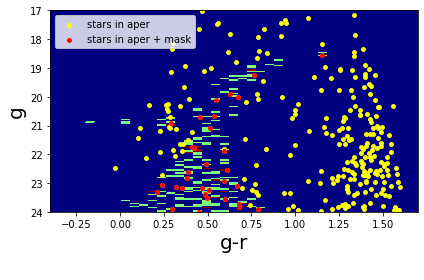

In [4]:
# read config file as online argument 
confg = "gawa.json"

# read config file
with open(confg) as fstream:
    param = json.load(fstream)

# Working & output directories 
workdir = param['out_paths']['workdir']
create_directory(workdir)
create_directory(os.path.join(workdir, 'tiles'))
print ('Survey : ', param['survey'])
print ('workdir : ', workdir)
tiles_filename = os.path.join(workdir, param['admin']['tiling']['tiles_filename'])

# create required data structure if not exist and update config 
if not param['input_data_structure'][param['survey']]['footprint_hpx_mosaic']:
    create_mosaic_footprint(param['footprint'][param['survey']], os.path.join(workdir, 'footprint'))
    param['footprint'][param['survey']]['mosaic']['dir'] = os.path.join(workdir, 'footprint')  

# split_area:
if param['input_data_structure'][param['survey']]['footprint_hpx_mosaic']: 
    survey_footprint = os.path.join(workdir, 'survey_footprint.fits')
    if not os.path.isfile(survey_footprint):
        create_survey_footprint_from_mosaic(param['footprint'][param['survey']], survey_footprint)
else:
    survey_footprint = param['footprint'][param['survey']]['survey_footprint']

if not os.path.isfile(tiles_filename):
    ntiles = hpx_split_survey(survey_footprint, param['footprint'][param['survey']], param['admin']['tiling'], tiles_filename)
    n_threads, thread_ids = split_equal_area_in_threads(param['admin']['nthreads_max'], tiles_filename)
    add_key_to_fits(tiles_filename, thread_ids, 'thread_id', 'int')
else:
    dat = read_FitsCat(tiles_filename)
    ntiles, n_threads = len(dat), np.amax(dat['thread_id']) 
    thread_ids = dat['thread_id']
    
print ('Ntiles / Nthreads = ', ntiles, ' / ', n_threads)

# prepare dslices 
compute_dslices(param['isochrone_masks'][param['survey']], param['gawa_cfg']['dslices'], workdir)

# compute cmd_masks 
print ('Compute CMD masks')
compute_cmd_masks(param['isochrone_masks'][param['survey']], param['out_paths'], param['gawa_cfg'])

futures = list()

with tqdm(total=len(thread_ids), file=sys.stdout) as pbar:
    pbar.set_description("Submit Parsls Tasks")

    for i in np.unique(thread_ids): 
        futures.append(gawa_thread_call(param, i))
        pbar.update()

print("Tasks Done:")

with tqdm(total=len(futures), file=sys.stdout) as pbar2:
    is_done = list()
    done_count = 0
    while is_done.count(True) != len(futures):
        is_done = list()
        for f in futures:
            is_done.append(f.done())

        if is_done.count(True) != done_count:
            done_count = is_done.count(True)
            pbar2.reset(total=len(futures))  
            pbar2.update(done_count)

        if done_count < len(futures):
            sleep(3)

In [5]:
gawa_concatenate(param)
print ('all done folks!')


Concatenation starts
              Nr. of duplicates = 0 / 51
              Final Nr of clusters : 51
all done folks!
